In [51]:
import numpy as np

def somme_des_logs(y):
    sommes = y.copy()
    for i in range(len(y)):
        for j in range(len(y[0])):
            sommes[i][j] = som_des_logs(y[i][j])
    return sommes




In [52]:
import math

def som_des_logs(n):
    somme = 0
    for i in range(1, n+1):
        somme += math.log(i)
    return somme


In [53]:
import numpy as np
import scipy.special

def salm(nchain, x, y, alpha, beta, gamma, tau, lambd, prop_sd):

    # Initialisation
    # res = np.ones((nchain + 1, 4))
    res = []
    res.append([alpha, beta, gamma, 1/np.sqrt(tau)])
    res_lambda = []
    res_lambda.append(lambd)
    #print(res[0][1])
    n = len(x)
    m = y.shape[1]
    logmu = np.zeros((n,m))
    for l in range(n):
        for k in range(m):
            logmu[l, k] = alpha + beta * np.log(10 + x[l]) + gamma * x[l] + lambd[l, k]
    mu = np.exp(logmu)


    acc_rates = np.zeros(3)

    print(res)
    print(res_lambda)
    for i in range(nchain):


        # Mise à jour de alpha
        alpha = res[i][0]
        prop = np.random.normal(alpha, prop_sd[0])  # marche aléatoire simple
        prop_logmu = np.zeros((n,m))
        for l in range(n):
            for k in range(m):
                prop_logmu[l, k] = prop + beta * np.log(10 + x[l]) + gamma * x[l] + lambd[l, k]
        if i<= 10:
            print(alpha, beta, gamma, lambd[1,1])
            print(prop_logmu[1,1])
        prop_mu = np.exp(prop_logmu)
        sum_log = somme_des_logs(y)
        top = - ((prop**2) / (2 * 1e6)) + np.sum(y * np.log(prop_mu) - sum_log - prop_mu)
        bottom = - ((alpha**2) / (2 * 1e6)) + np.sum(y * np.log(mu) - sum_log - mu)
        acc_prob = np.exp(top - bottom)  # la proportion des noyaux est de 1 (symétrie du noyau)
        print("acc", acc_prob, "alpha", alpha, "prop", prop)
        if np.random.uniform(0, 1) < min(1, acc_prob):
            alpha = prop
            logmu = prop_logmu
            mu = prop_mu
            acc_rates[0] += 1

        # Mise à jour de beta
        print(i)
        beta = res[i][1]
        prop = np.random.normal(beta, prop_sd[1])  # marche aléatoire simple
        for l in range(n):
            for k in range(m):
                prop_logmu[l, k] = alpha + prop * np.log(10 + x[l]) + gamma * x[l] + lambd[l, k]
        prop_mu = np.exp(prop_logmu)
        sum_log = somme_des_logs(y)
        top = - ((prop**2) / (2 * 1e6)) + np.sum(y * np.log(prop_mu) - sum_log - prop_mu)
        bottom = - ((beta**2) / (2 * 1e6)) + np.sum(y * np.log(mu) - sum_log - mu)
        acc_prob = np.exp(top - bottom)  # la proportion des noyaux est de 1 (symétrie du noyau)

        if np.random.uniform(0, 1) < min(1, acc_prob):
            beta = prop
            logmu = prop_logmu
            mu = prop_mu
            acc_rates[1] += 1

        # Mise à jour de gamma
        gamma = res[i][2]
        prop = np.random.normal(gamma, prop_sd[2])  # marche aléatoire simple
        for l in range(n):
            for k in range(m):
                prop_logmu[l, k] = alpha + beta * np.log(10 + x[l]) + prop * x[l] + lambd[l, k]
        prop_mu = np.exp(prop_logmu)
        sum_log = somme_des_logs(y)
        top = - ((prop**2) / (2 * 1e6)) + np.sum(y * np.log(prop_mu+1e-10) - sum_log - prop_mu)
        bottom = - ((gamma**2) / (2 * 1e6)) + np.sum(y * np.log(mu) - sum_log - mu)
        acc_prob = np.exp(top - bottom)  # la proportion des noyaux est de 1 (symétrie du noyau)

        if np.random.uniform(0, 1) < min(1, acc_prob):
            gamma = prop
            logmu = prop_logmu
            mu = prop_mu
            acc_rates[2] += 1

        # Mise à jour de tau
        tau = np.random.gamma(1e-3 + (n + m) / 2, 1e-3 + 0.5 * np.sum(lambd**2))

        # Mise à jour de lambd
        for k in range(n):
            for l in range(m):
                prop = np.random.normal(lambd[k,l], prop_sd[3])
                for o in range(n):
                    for p in range(m):
                        prop_logmu[o, p] = alpha + beta * np.log(10 + x[o]) + gamma* x[o] + prop
                prop_mu = np.exp(prop_logmu)
                top = - (prop**2 *tau/ 2)- prop_mu[k,l] + np.log(prop_mu[k,l]**y[k, l]) - som_des_logs(y[k][l])
                bottom = - (lambd[k, l]**2 * tau/ 2)- mu[k,l] + np.log(mu[k, l]**y[k, l]) - som_des_logs(y[k][l])
                acc_prob = np.exp(top - bottom)

                if np.random.uniform(0, 1) < min(1, acc_prob):
                    lambd[k, l] = prop
                    logmu= prop_logmu
                    mu = prop_mu

        # Mise à jour de la chaîne de Markov et de lambd
        res.append([alpha, beta, gamma, 1/np.sqrt(tau)])
        res_lambda.append(lambd)

    my_list = {"chain": res, "acc_rates": acc_rates}
    return my_list



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, gamma, poisson

# Récupération des données
Ndoses = 6
Nplates = 3
#y = np.array([[15, 16, 16],
 #             [27, 33, 20],
 #            [21, 18, 26],
 #             [41, 38, 27],
 #             [29, 21, 33],
  #            [60, 41, 42]])

y = np.array([[15, 21, 29],
              [16, 18, 21],
              [16, 26, 33],
              [27, 41, 69],
              [33, 38, 41],
              [20, 27, 42]])

x = np.array([0, 10, 33, 100, 333, 1000])

# Initialisation
alpha = 0.0
beta = 0
gamma = 0
tau = 0.1
lambd = np.random.normal(loc=0, scale=np.sqrt(1/tau), size=(6, 3))

resultat = salm(int(1e4), x, y, alpha, beta, gamma, tau, lambd, prop_sd=[0.3874, 0.1054, 0.00004525, 0.08077])  # prop_sd choisi pour avoir une apparence de chaîne cohérente

resultat_chain = resultat["chain"][1000:]  # enlever les 1000 premiers (burn-in)

moychain = np.mean(resultat_chain, axis=0)  # moyenne
sdchain = np.std(resultat_chain, axis=0)  # écart-type

print("alpha est estimé à", moychain[0], "avec un écart-type de", sdchain[0])
print("beta est estimé à", moychain[1], "avec un écart-type de", sdchain[1])
print("gamma est estimé à", moychain[2], "avec un écart-type de", sdchain[2])
print("sigma est estimé à", moychain[3], "avec un écart-type de", sdchain[3])



Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
acc 1.3077938964166974e-31 alpha 2.371418377482427 prop 2.4724816051999325
7502
acc 1.4853585798826271e-46 alpha 2.371418377482427 prop 1.9988549797461848
7503
acc 6.931227802188172e-38 alpha 2.371418377482427 prop 2.6143986219357185
7504
acc 1.1014154584082005e-41 alpha 2.371418377482427 prop 2.034291939166232
7505
acc 1.0804153429392386e-98 alpha 2.371418377482427 prop 1.505852602708686
7506
acc 4.1550476743265114e-30 alpha 2.371418377482427 prop 2.3310042688646506
7507
acc 5.129343560844763e-61 alpha 2.371418377482427 prop 1.8263704157438065
7508
acc 1.918623100983292e-96 alpha 2.371418377482427 prop 3.0912990483447573
7509
acc 5.436675486674393e-27 alpha 2.371418377482427 prop 2.333298436732325
7510
acc 1.9400404554222168e-39 alpha 2.371418377482427 prop 2.083906819773297
7511
acc 2.6580935011398918e-51 alpha 2.371418377482427 prop 1.8850034679202408
7512
acc 4.64874576972423e-31 alpha 2.371418377482427 p

In [ ]:
print(resultat)

{'chain': [[0.0, 0, 0, 3.162277660168379], [0.0, 0, 0.005563918999510391, 0.04287975164688417], [-0.05405554408312853, 0, 0.005563918999510391, 0.05462116342522352], [-0.06608542950720728, 0, 0.005563918999510391, 0.03517180012189858], [-0.09719821624376337, 0, 0.005563918999510391, 0.04783529917841645], [-0.14770210829628017, -0.0003710690669274691, 0.005563918999510391, 0.07370513255173183], [-0.1772290601295367, -0.0003710690669274691, 0.005563918999510391, 0.03588648982673441], [-0.1614630473435375, -0.0003710690669274691, 0.005563918999510391, 0.05777475287360662], [-0.21379990045056585, -0.0003710690669274691, 0.005563918999510391, 0.0955328348284349], [-0.23917883898466263, -0.0003710690669274691, 0.005563918999510391, 0.05339533983081877], [-0.202178737048831, -0.0003710690669274691, 0.005563918999510391, 0.05628353801165829], [-0.21082003842196506, -0.0003710690669274691, 0.005563918999510391, 0.05359610966869139], [-0.21624360858566047, -0.0003710690669274691, 0.0055639189995

In [ ]:

# Implémentation de la méthode MCMC (Hastings within Gibbs)
def model(y, x, nchain, alpha, beta, gamma, tau, lambda_):
    n = len(x)
    m = y.shape[1]
    res = np.zeros((nchain, 4))
    for k in range(nchain):
        for i in range(n):
            for j in range(m):
                mu_ij = np.exp(alpha + beta * np.log(x[i] + 10) + gamma * x[i] + lambda_[i, j])
                lambda_[i, j] = np.random.normal(0, np.sqrt(1/tau))
                y[i, j] = np.random.poisson(mu_ij)
        alpha = np.random.normal(alpha_star, np.sqrt(1/1e6))
        beta = np.random.normal(0, np.sqrt(1/1e6))
        gamma = np.random.normal(0, np.sqrt(1/1e6))
        tau = np.random.gamma(0.001 + 9 * n * m, 0.001 + 0.5 * np.sum(lambda_**2))
        res[k] = [alpha, beta, gamma, 1/np.sqrt(tau)]
    return res

results = model(y, x, 10000, alpha_star, beta, gamma, tau, lambd)

# Récupération des résultats
burn_in = 1000
results_post_burn_in = results[burn_in:, :]
moychain = np.mean(results_post_burn_in, axis=0) # moyenne
sdchain = np.std(results_post_burn_in, axis=0) # écart type

print("Alpha est estimé à", moychain[0], "avec un écart-type de", sdchain[0])
print("Beta est estimé à", moychain[1], "avec un écart-type de", sdchain[1])
print("Gamma est estimé à", moychain[2], "avec un écart-type de", sdchain[2])
print("Sigma est estimé à", moychain[3], "avec un écart-type de", sdchain[3])

# Visualisation des résultats
plt.figure(figsize=(10, 10))

# Allure des densités pour Alpha, Beta, Gamma et Sigma
plt.subplot(2, 2, 1)
plt.title("Density de Alpha")
plt.hist(results_post_burn_in[:, 0], bins=30, density=True)
plt.subplot(2, 2, 2)
plt.title("Density de Beta")
plt.hist(results_post_burn_in[:, 1], bins=30, density=True)
plt.subplot(2, 2, 3)
plt.title("Density de Gamma")
plt.hist(results_post_burn_in[:, 2], bins=30, density=True)
plt.subplot(2, 2, 4)
plt.title("Density de Sigma")
plt.hist(results_post_burn_in[:, 3], bins=30, density=True)

plt.tight_layout()
plt.show()


NameError: name 'alpha_star' is not defined

In [ ]:
mean = [moychain[0], moychain[1], moychain[2], moychain[3]]
sd = [sdchain[0], sdchain[1], sdchain[2], sdchain[3]]

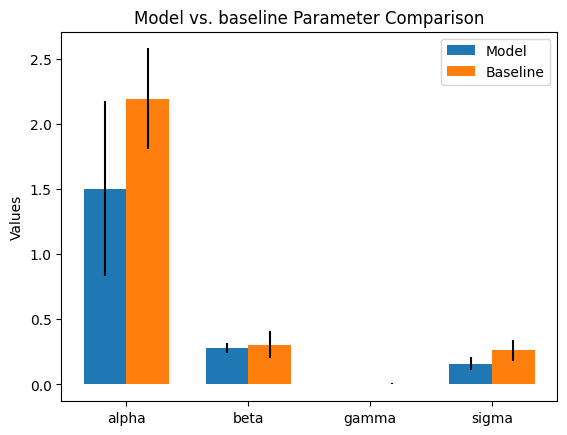

In [ ]:
#Baseline here indicates Breslow and Clayton estimates
def plot_parameter_comparison(params_df):
    ind = np.arange(len(params_df))  # the x locations for the groups
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots()
    rects1 = ax.bar(ind - width / 2, params_df['mean'], width, label='Model', yerr=params_df['std'])
    rects2 = ax.bar(ind + width / 2, params_df['mean_base'], width, label='Baseline', yerr=params_df['std_base'])

    # Add some text for labels, title, and custom x-axis tick labels
    ax.set_ylabel('Values')
    ax.set_title('Model vs. baseline Parameter Comparison')
    ax.set_xticks(ind)
    ax.set_xticklabels(['alpha', 'beta', 'gamma', 'sigma'])
    ax.legend()

    plt.show()

#results_summary = results.describe().T
import pandas as pd
params_df = pd.DataFrame()
params_df['mean'] = mean
params_df['std'] = sd
#Breslow and Clayton estimates
params_df['mean_base'] = [2.193, 0.3059, 69.577*(10**(-4)), 0.2608]
params_df['std_base'] = [0.3874, 0.1054, 4.525*(10**(-4)), 0.08077]
params_df.reset_index(drop=True, inplace=True)

plot_parameter_comparison(params_df)